#  Task 2: Extract prevalent topics from Twitter messages

## 🎯 Objective

- The goal of this project is to **extract the most frequent topics** discussed in tweets related to a specific city or region using **Natural Language Processing (NLP)** techniques.
- This analysis helps identify **trends, public concerns, and popular discussions** by processing tweet content.
- The insights can support **local researchers, journalists, or policymakers** by showing what people are actively talking about in a particular location.

## Diagram of the project

![ScholarAI Diagram](https://i.postimg.cc/jj4GrYzg/Diagram-1.png)

# Notebook Installations

In [1]:
!pip install -qU tweepy

In [2]:
!pip install -qU bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the

In [3]:
!pip install -qU langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
import tweepy
import time
import pandas as pd
import re
from kaggle_secrets import UserSecretsClient
from wordcloud import WordCloud


# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

from IPython.display import HTML
import pandas as pd
from tweepy.errors import TooManyRequests
import pandas as pd
from IPython.display import HTML

import matplotlib.pyplot as plt
import numpy as np
from bertopic import BERTopic
from collections import Counter

from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from langdetect import detect

2025-05-19 18:11:30.902078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747678291.090547      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747678291.145988      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [6]:
user_secrets = UserSecretsClient()
# access_token = user_secrets.get_secret("access_token")
# access_token_secret = user_secrets.get_secret("access_token_secret")
bearer_token = user_secrets.get_secret("BEARER_TOKEN")
# consumer_key = user_secrets.get_secret("consumer_key")
# consumer_secret = user_secrets.get_secret("consumer_secret")

# Step 1: Data Collection

I used the **Twitter API v2** to collect recent tweets related to Uzbekistan by searching for keywords like **"Tashkent"**, **"Uzbekistan"**, and **#Uzbekistan.** Since I don't have access to location-based filters, I relied on these keywords along with the language filter **lang:en** to get relevant tweets.

I fetched tweets in multiple batches using **Tweepy**, with a delay between requests to respect the rate limit. Each tweet includes the text, author ID, language, creation time, and context annotations (if available).

In [7]:
client = tweepy.Client(bearer_token=bearer_token)

In [8]:
# Pre-define df in case all branches fail
df = None

query = (
    "(Tashkent OR Uzbekistan OR #Uzbekistan OR #Tashkent OR Samarqand OR Samarkand) "
    "-is:retweet lang:en"
)

try: 
    tweet = client.search_recent_tweets(
        query=query,
        tweet_fields=['context_annotations', 'created_at', 'author_id', 'lang'],
        max_results=100
    )

    if tweet.data is not None:
        tweet_list = []
        for t in tweet.data:
            tweet_list.append({
                "id": t.id,
                "text": t.text,
                "created_at": t.created_at,
                "author_id": t.author_id,
                "lang": t.lang,
                "context_annotations": t.context_annotations if hasattr(t, "context_annotations") else None
            })

        df = pd.DataFrame(tweet_list)
        print(df.head())
    else:
        print("No tweets returned.")

except TooManyRequests:
    print("Twitter API limit reached. Loading fallback CSV...")
    df = pd.read_csv("/kaggle/input/2024-us-presidential-elections-twitter-data/final_raw.csv")
    print(df.head())

finally:
    if df is not None:
        df.to_csv('submission.csv', index=False)

        def create_download_link(title="Download CSV file", filename="submission.csv"):  
            html = f'<a href="{filename}">{title}</a>'
            return HTML(html)

        create_download_link(filename='submission.csv')
    else:
        print("No DataFrame available to save.")

Twitter API limit reached. Loading fallback CSV...
              Tweet ID            Username  \
0  1798142586911342936          Rabbit1873   
1  1798142575112769914      Chrissi Miller   
2  1798142544762830918  Pedro Da Conceicao   
3  1798142432388714849              Ben 🇺🇲   
4  1798142320958943735  🇺🇸Proud American🇮🇹   

                                                Text  \
0  @JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...   
1  @PaulStanleyLive #PresidentDonaldTrump wins th...   
2  @tomorrowsmps I believe I am the youngest PPC ...   
3  I am already saying Democrats will cheat even ...   
4  @BryanDeanWright Republican AG’s should prosec...   

                             Date  Retweets  Likes    Weight  
0  Tue Jun 04 23:59:35 +0000 2024         2      3  0.622459  
1  Tue Jun 04 23:59:32 +0000 2024         0      0  0.622459  
2  Tue Jun 04 23:59:25 +0000 2024         0      0  0.982014  
3  Tue Jun 04 23:58:58 +0000 2024         0      0  0.500000  
4  Tue Jun 04 23:58:

In [9]:
df.shape

(26425, 7)

In [10]:
df.head()

,Tweet ID,Username,Text,Date,Retweets,Likes,Weight
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797


In [11]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
Tweet ID    0
Username    2
Text        0
Date        0
Retweets    0
Likes       0
Weight      0
dtype: int64


In [12]:
print(f"The types of the data: \n{df.dtypes}\n")

The types of the data: 
Tweet ID      int64
Username     object
Text         object
Date         object
Retweets      int64
Likes         int64
Weight      float64
dtype: object



In [13]:
df.drop_duplicates('Text', inplace=True)
print(df.shape)
df.head()

(26314, 7)


,Tweet ID,Username,Text,Date,Retweets,Likes,Weight
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797


# Step 2: Data Preprocessing


* **Text Cleaning:** Remove any HTML tags, special characters, numbers, and other non-alphabetic characters.
* **Tokenization:** Split the reviews into individual words (tokens).
* **Stop Words Removal:** Remove common words that do not contribute to the sentiment, such as 'and', 'the', 'is', etc.
* **Lemmatization:** Reduce words to their base or root form.


In [14]:
def detect_lang(text):
    try:
        return detect(text)
    except:
        return 'unknown'

In [15]:
df['Language'] = df['Text'].apply(lambda x: detect_lang(x))
df.head()

,Tweet ID,Username,Text,Date,Retweets,Likes,Weight,Language
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459,en
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459,en
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014,en
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000,en
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797,en


In [16]:
df['Language'].value_counts()

Language
en         24617
de           185
es           178
nl           142
id           119
fr           105
af            96
pt            84
no            75
ro            68
fi            58
et            58
tr            47
it            46
ca            41
tl            37
da            37
sl            35
sv            30
unknown       30
so            28
sw            27
pl            26
vi            26
ja            18
cy            17
lt            15
hr            13
hu            11
zh-cn          8
sq             7
sk             7
lv             5
cs             5
fa             3
ar             3
hi             2
ur             2
uk             1
he             1
ko             1
Name: count, dtype: int64

In [17]:
df = df[df['Language'] == 'en'].reset_index(drop=True)
print(df.shape)
df.head()

(24617, 8)


,Tweet ID,Username,Text,Date,Retweets,Likes,Weight,Language
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459,en
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459,en
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014,en
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000,en
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797,en


In [18]:
def clean_for_bertopic(text):
    """
    Lightly clean tweets for BERTopic (BERT-based models).
    Preserves stopwords and sentence structure for semantic understanding.

    Removes: HTML tags, URLs, mentions, hashtag symbols.
    """
    import re

    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r"@\w+", '', text)  # Remove mentions
    text = re.sub(r"#", '', text)  # Remove hashtag symbol only
    return text.strip().lower()

In [19]:
def clean_for_lda(text, wl=WordNetLemmatizer(), 
                  stop_words=set(stopwords.words('english') + ['http', 'https', 'amp', 'com'])):
    """
    Clean tweets for LDA/NMF topic modeling by removing noise and reducing words to their root form.

    Steps:
    - Remove HTML, URLs, mentions, hashtags
    - Lowercase
    - Tokenize
    - Remove stopwords and non-alphabetic tokens
    - Lemmatize
    """
    import re
    from nltk.tokenize import word_tokenize

    # Remove HTML, links, mentions, hashtag symbols
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r"#", '', text)

    # Tokenize and clean
    words = word_tokenize(text.lower())
    filtered_words = [wl.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]

    return ' '.join(filtered_words)

In [20]:
print(df.columns)

Index(['Tweet ID', 'Username', 'Text', 'Date', 'Retweets', 'Likes', 'Weight',
       'Language'],
      dtype='object')


In [21]:
df.head()

,Tweet ID,Username,Text,Date,Retweets,Likes,Weight,Language
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459,en
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459,en
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014,en
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000,en
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797,en


In [22]:
%%time
# For BERTopic
df['CleanText_BERT'] = df['Text'].astype(str).apply(clean_for_bertopic)

# For LDA
df['CleanText_LDA'] = df['Text'].astype(str).apply(clean_for_lda)

CPU times: user 8.53 s, sys: 323 ms, total: 8.86 s
Wall time: 8.86 s


In [23]:
df.drop_duplicates('CleanText_BERT', inplace=True) 
df.drop_duplicates('CleanText_LDA', inplace=True) 
df.reset_index(drop=True, inplace=True)

In [24]:
print(df.shape)
df.head()

(23694, 10)


,Tweet ID,Username,Text,Date,Retweets,Likes,Weight,Language,CleanText_BERT,CleanText_LDA
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459,en,re: breaking: garland to launch 'election thre...,breaking garland launch threat task force go a...
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459,en,presidentdonaldtrump wins the presidential ele...,presidentdonaldtrump win presidential election
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014,en,i believe i am the youngest ppc standing in th...,believe youngest ppc standing election
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000,en,i am already saying democrats will cheat even ...,already saying democrat cheat even keep beggin...
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797,en,republican ag’s should prosecute the 51 intell...,republican ag prosecute intelligence official ...


# **Step 3: Entity Analysis**

* **Hashtag**: Extracted all words starting with #, counted their frequency, and visualized the top 10 most used hashtags.
* **Mentions:** Extracted all mentions (@username) from tweet text, counted their occurrences, and visualized the top 10 most mentioned users.
* **Active Users:** Identified tweet authors from the Username field, ranked users by number of tweets, and plotted the top 10 most active users.

### Hashtags

In [25]:
# function to print all the hashtags in a text
def extract_hashtags(text):
    return [word[1:] for word in text.split() if word.startswith('#')]

In [26]:
hashtag_list = []
for i in range(len(df['Text'])):
    hashtags = extract_hashtags(df['Text'][i])
    if len(hashtags) != 0:
        hashtag_list.append(hashtags)

hashtag_list[:5]

[['PresidentDonaldTrump'],
 ['मोदी_चूरचूर_लड्डू'],
 ['GoogleAlerts'],
 ['GoogleAlerts'],
 ['GoogleAlerts']]

In [27]:
# flatten the list of hashtag lists
flat_hashtag_list = [hashtag.lower() for sublist in hashtag_list for hashtag in sublist]

# count the hashtags
hashtag_counts = Counter(flat_hashtag_list)

# get the top 10 most common hashtags
top_10_hashtags = hashtag_counts.most_common(10)

for tag, count in top_10_hashtags:
    print(f"#{tag}: {count}")

#trump: 98
#maga: 77
#trump2024: 68
#smartnews: 43
#kamalaharris: 39
#election2024: 38
#donaldtrump: 36
#biden: 34
#election: 25
#harriswalz2024: 23


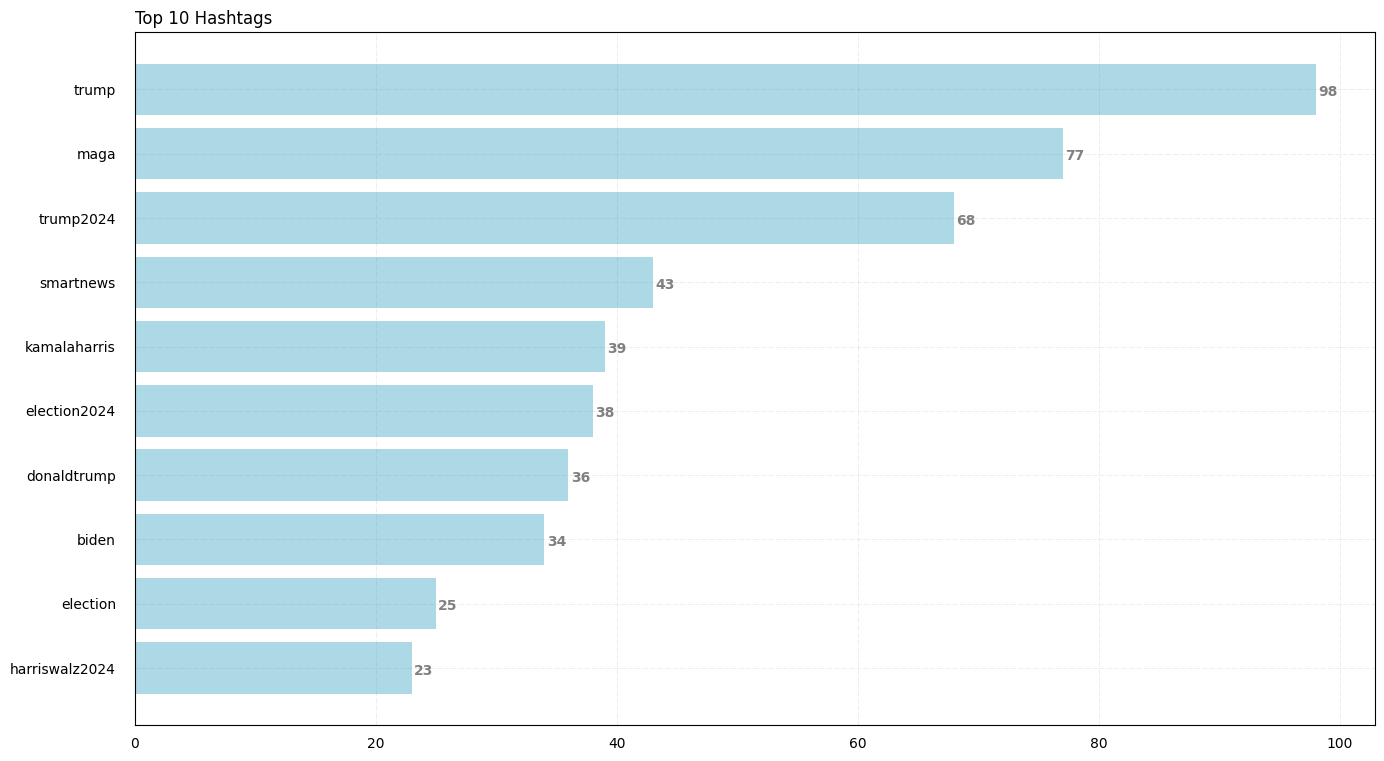

In [28]:
hashtags = [top_10_hashtags[i][0] for i in range(len(top_10_hashtags))]
count_hashtags = [top_10_hashtags[i][1] for i in range(len(top_10_hashtags))]

# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))

# Horizontal Bar Plot
ax.barh(hashtags, count_hashtags, color='lightblue')

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Top 10 Hashtags', loc='left')

# Show Plot
plt.show()

### Mentions

In [29]:
# function to print all the users mentioned in a tweet
def extract_users(text):
    return [word[1:] for word in text.split() if word.startswith('@')]

In [30]:
users = [extract_users(text) for text in df['Text'] if extract_users(text)]
users[:5]

[['JackPosobiec'],
 ['PaulStanleyLive'],
 ['tomorrowsmps'],
 ['BryanDeanWright'],
 ['WashTimes']]

In [31]:
# flatten the list of users
flat_users_list = [user.lower() for sublist in users for user in sublist]

# count the users
user_counts = Counter(flat_users_list)

# get the top 10 most common users
top_10_users = user_counts.most_common(10)

for mentions, count in top_10_users:
    print(f"@{mentions}: {count}")

@mike_pence: 663
@youtube: 455
@elonmusk: 353
@kamalaharris: 336
@realdonaldtrump: 336
@robertkennedyjr: 257
@harris_wins: 180
@vivekgramaswamy: 156
@gunthereagleman: 142
@jdvance: 142


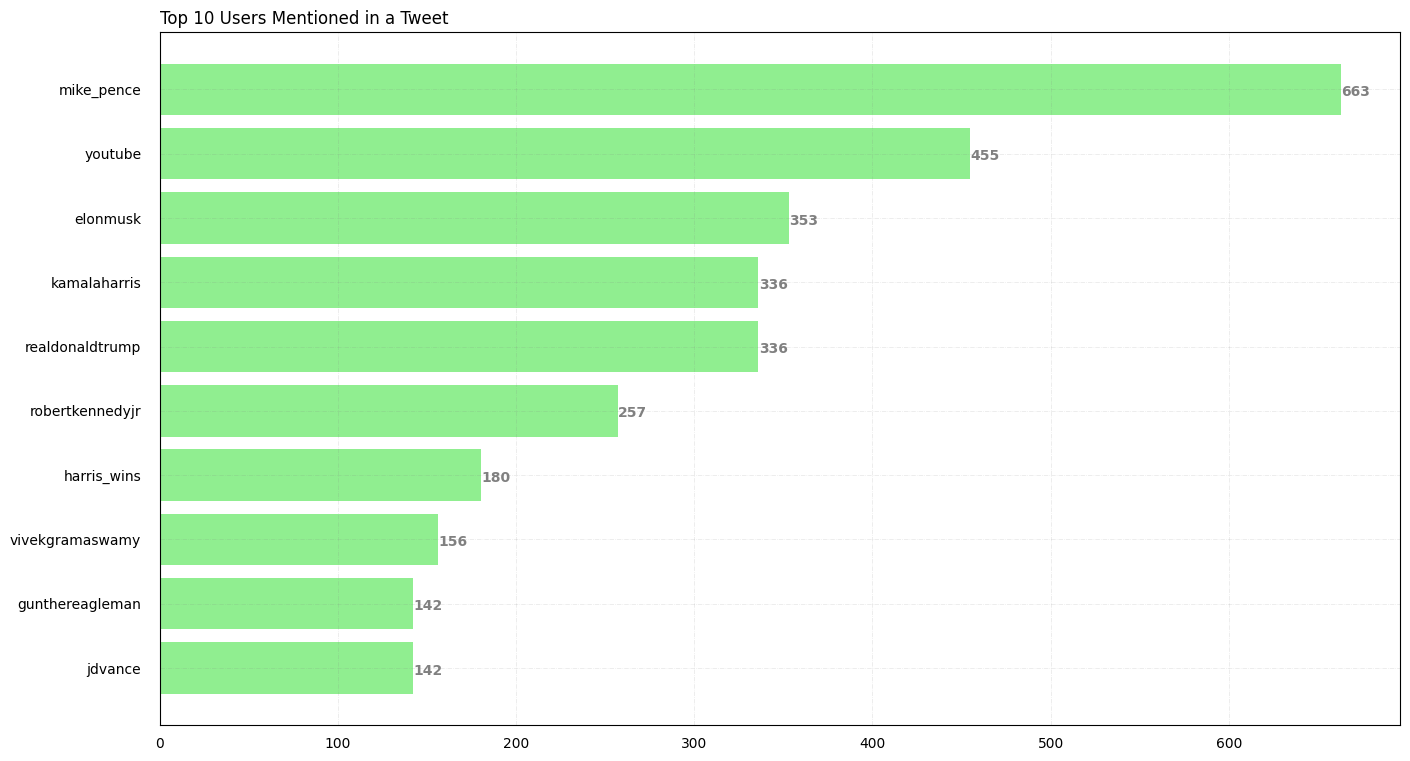

In [32]:
users = [top_10_users[i][0] for i in range(len(top_10_users))]
count_users = [top_10_users[i][1] for i in range(len(top_10_users))]

# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))

# Horizontal Bar Plot
ax.barh(users, count_users, color='lightgreen')

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Top 10 Users Mentioned in a Tweet', loc='left')

# Show Plot
plt.show()

### Active Users

In [33]:
df['Username'].value_counts()[:10]

Username
Vivek G. Ramaswamy - Commentary News    112
HaleyFan 🇵🇸                              81
RFK Jr's brain worm 🪱                    71
Mike Pence's Other Mother 🟧🟦🟪            49
Vivek Ramaswamy                          48
MA for RFK Jr                            27
Richard Smit 🦅🚁💰🇳🇱🇺🇸🇬🇧🇮🇱🇺🇦🇹🇼             27
Mike                                     24
Bulldogs4VivekOhio                       23
𝐁𝐄𝐀𝐒𝐓 ᴰᴱᴹᴼᶜᴿᴬᵀ ⁻ ⁿᵒᵗ ᵗʰᵉ ᶠᵘⁿ ᵏⁱⁿᵈ        22
Name: count, dtype: int64

In [34]:
usernames = df['Username'].value_counts().index.tolist()
count_usernames = df['Username'].value_counts().values.tolist()

In [35]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="IPython.core.pylabtools")

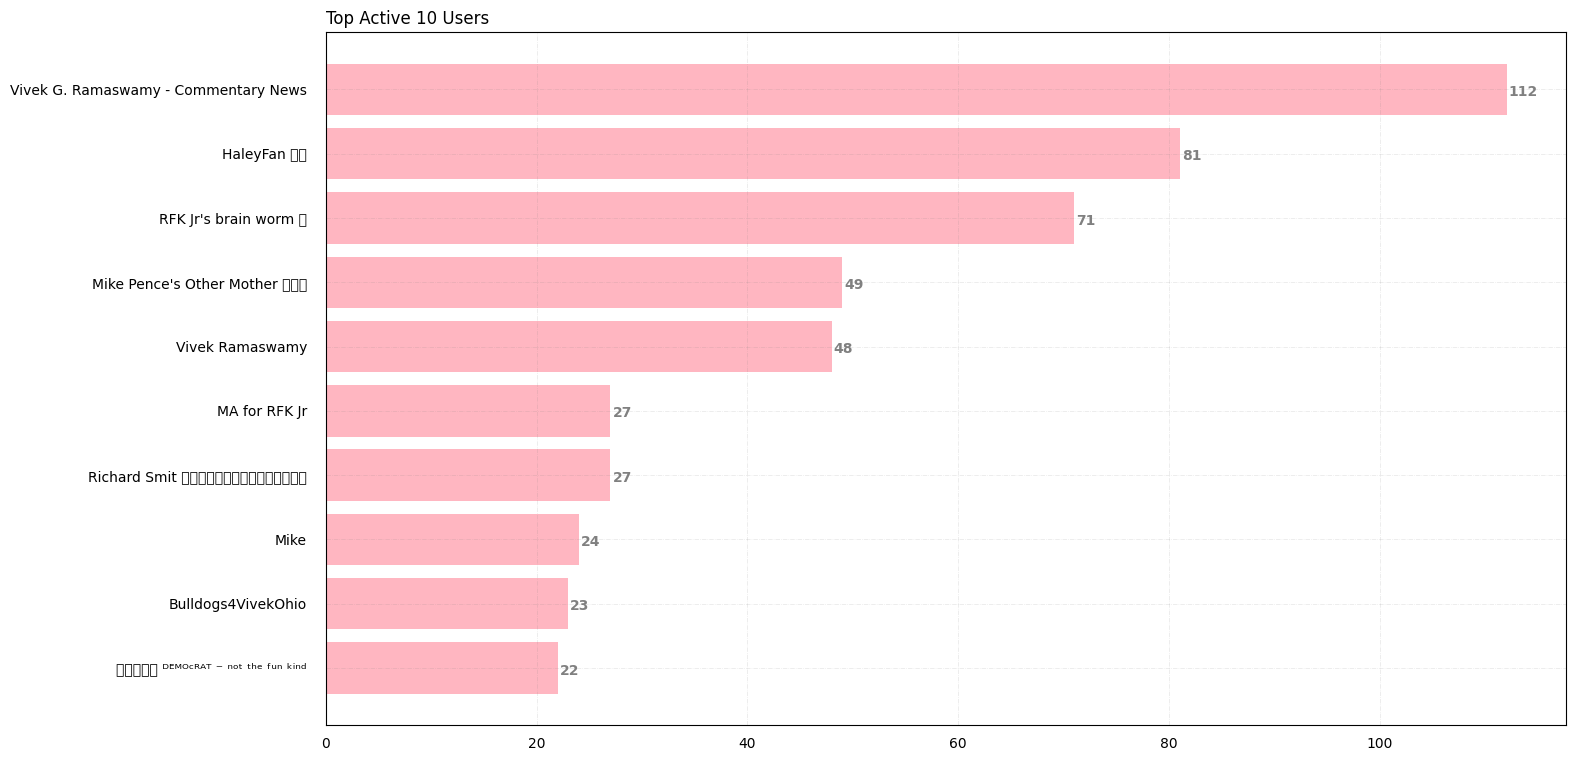

In [36]:
# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))
plt.rcParams['font.family'] = 'DejaVu Sans'

# Horizontal Bar Plot
ax.barh(usernames[:10], count_usernames[:10], color='lightpink')

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Top Active 10 Users', loc='left')

# Show Plot
plt.show()

### Common Words in Tweets

In [37]:
tweets = df['CleanText_LDA'].dropna().tolist()
long_string = ','.join(tweets)

In [38]:
len(long_string)

2111305

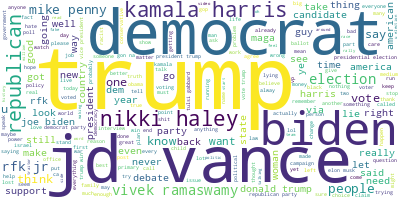

In [39]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=10000, contour_width=5, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [40]:
# count the words
word_counts = Counter(long_string.split())

# get the top 10 most common hashtags
top_10_words = word_counts.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

trump: 6779
election: 3188
biden: 3053
harris: 2695
democrat: 2542
republican: 2531
vance: 2457
kamala: 2401
rfk: 2039
haley: 2025


# Step 4: Topic Modeling

### Option 1: BERTopic Technique

In [41]:
df.columns

Index(['Tweet ID', 'Username', 'Text', 'Date', 'Retweets', 'Likes', 'Weight',
       'Language', 'CleanText_BERT', 'CleanText_LDA'],
      dtype='object')

In [42]:
df.drop(['Tweet ID', 'Text', 'Date', 'Retweets', 'Likes', 'Weight', 'Language'], axis=1, inplace=True)
df.head()

,Username,CleanText_BERT,CleanText_LDA
0,Rabbit1873,re: breaking: garland to launch 'election thre...,breaking garland launch threat task force go a...
1,Chrissi Miller,presidentdonaldtrump wins the presidential ele...,presidentdonaldtrump win presidential election
2,Pedro Da Conceicao,i believe i am the youngest ppc standing in th...,believe youngest ppc standing election
3,Ben 🇺🇲,i am already saying democrats will cheat even ...,already saying democrat cheat even keep beggin...
4,🇺🇸Proud American🇮🇹,republican ag’s should prosecute the 51 intell...,republican ag prosecute intelligence official ...


In [43]:
tweets = df['CleanText_BERT'].dropna().tolist()
tweets[:10]

["re: breaking: garland to launch 'election threat task force' to go after anyone questioning election integrity in 2024   he will create fbi attack teams...  fbi = gestapo",
 'presidentdonaldtrump wins the presidential election in 2024',
 'i believe i am the youngest ppc standing in this election, 18 y/o.',
 'i am already saying democrats will cheat even more in 2024. i keep begging republicans to safeguard elections now before the election. but... well, you know.',
 'republican ag’s should prosecute the 51 intelligence officials who signed a letter saying that the hunter biden laptop was “russian disinformation ” for election interference',
 'how do i say “i told you so, without saying “i told you so”? and y’all didn’t think this was all for the 2024 ‘election’. many american dumocrats are waking up, 20million illegal aliens are now available to replace them .... thank ur uncle pedo pete (&lt; ask hunter why)',
 'lok sabha election results 2024 reactions live updates: ‘decisive moral

In [44]:
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True)

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

umap_model = UMAP(n_neighbors=15, n_components=25, min_dist=0.01)

hdbscan_model = HDBSCAN(min_cluster_size=80, min_samples=50,
                        gen_min_span_tree=True,
                        prediction_data=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [45]:
model = BERTopic(
    ctfidf_model=ctfidf_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    top_n_words=10,
    language='english',
    calculate_probabilities=True,
    verbose=True
)     

topics, probs = model.fit_transform(tweets)

2025-05-19 18:13:40,223 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/741 [00:00<?, ?it/s]

2025-05-19 18:13:49,134 - BERTopic - Embedding - Completed ✓
2025-05-19 18:13:49,135 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-19 18:14:29,015 - BERTopic - Dimensionality - Completed ✓
2025-05-19 18:14:29,022 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

In [46]:
topic_info = model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5581,-1_trump_in_for_that,"[trump, in, for, that, it, republican, of, you...",[well nikki haley said a vote for biden is a v...
1,0,2062,0_vance_jd_he_his,"[vance, jd, he, his, vp, be, on, is, it, for]","[it’s going to be jd vance., jd vance, vivek r..."
2,1,1934,1_rfk_jr_he_his,"[rfk, jr, he, his, kennedy, on, with, him, tha...","[just do it vote rfk jr. 2024 !!, i am with y..."
3,2,1752,2_kamala_harris_she_her,"[kamala, harris, she, her, president, for, bid...","[kamala harris the next president, the real ka..."
4,3,1583,3_election_2024_us_will,"[election, 2024, us, will, 2020, in, president...","[the 2024 election results!, are democrats try..."
5,4,1528,4_democrat_republican_party_you,"[democrat, republican, party, you, are, vote, ...",[he lies about everything the democratic way.....
6,5,1494,5_biden_joe_he_his,"[biden, joe, he, his, president, that, you, it...","[getting joe biden as president, it was biden ..."
7,6,1426,6_nikki_haley_she_her,"[nikki, haley, she, her, would, trump, you, ha...","[he is talking about nikki haley?, ♥️♥️♥️ nikk..."
8,7,1296,7_pence_mike_hang_was,"[pence, mike, hang, was, he, vp, did, what, hi...","[just like mike pence is donald trump.., he’s ..."
9,8,1238,8_ramaswamy_vivek_via_he,"[ramaswamy, vivek, via, he, with, be, indian, ...","[anyone that’s not vivek ramaswamy, and i sup..."


In [47]:
# model.reduce_topics(tweets, nr_topics=25)
# model.get_topic_info()

In [48]:
model.visualize_barchart(top_n_topics=32)

In [49]:
model.visualize_topics()

In [50]:
model.visualize_heatmap()

In [51]:
model.get_representative_docs()

{-1: ['well nikki haley said a vote for biden is a vote for harris. she has been running the country in the ground the last 3 1/2 years. at least the moderates know who they will be voting for unlike joe "bernie sanders" biden. she is bernie 2.0 so there you have it.',
  'i guess i have been recently been thinking it doesn’t really matter much for the 2024 election. trump is who people are going to vote for or not vote for. it will have little effect. what needs to be focused on who will be set up for 2028. i like ben but he is to soft spoken',
  'i would be great so we can see more of him &amp; what he will vote for.  it could help him in 2028.  would a good ticket vance - ramaswamy.  i don’t trust vivek yet.'],
 0: ['it’s going to be jd vance.',
  'jd vance, vivek ramaswamy',
  'jd vance be like'],
 1: ['just do it  vote rfk jr. 2024 !!',
  'i am with you. rfk, jr may do this. vote rfk, jr.',
  'rfk jr. 2024 !!'],
 2: ['kamala harris the next president',
  'the real kamala harris 👇',